<div style="text-align: center;" >
<h1 style="margin-top: 0.2em; margin-bottom: 0.1em;">Descriptive Analysis</h1>
<h4 style="margin-top: 0.7em; margin-bottom: 0.3em; font-style:italic">


Basic statistics, frequencies, word clouds and sentiment analysis

</div>
<br>

In [1]:
#Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from wordcloud import WordCloud
from transformers import pipeline

[nltk_data] Downloading package punkt to C:\Users\Jannik
[nltk_data]     Wirtheim\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Jannik
[nltk_data]     Wirtheim\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Temporal trends for posts and comments

In [2]:
# Import raw and preprocessed data
preprocessed_posts = pd.read_csv('c:/Users/Jannik Wirtheim/OneDrive/Dokumente/Privat/Bildung/M. Sc. Social and Economic Data Science/2. Semester/Deep Learning for Social Sciences/Project/data/preprocessed_posts.csv')
raw_posts = pd.read_csv('c:/Users/Jannik Wirtheim/OneDrive/Dokumente/Privat/Bildung/M. Sc. Social and Economic Data Science/2. Semester/Deep Learning for Social Sciences/Project/data/raw_posts.csv')
raw_comments = pd.read_csv('c:/Users/Jannik Wirtheim/OneDrive/Dokumente/Privat/Bildung/M. Sc. Social and Economic Data Science/2. Semester/Deep Learning for Social Sciences/Project/data/raw_comments.csv')

In [3]:
# Merge preprocessed_posts DataFrame with raw_posts DataFrame on 'id' column to get created_utc column
preprocessed_posts = preprocessed_posts.merge(raw_posts[['id', 'created_utc']], on='id', how='left')

# Convert the 'created_utc' column in readable date
preprocessed_posts["created_utc"] = pd.to_datetime(preprocessed_posts["created_utc"], unit='s')
raw_comments["created_utc"] = pd.to_datetime(raw_comments["created_utc"], unit='s')

# Extract the year from the 'created_utc' column
preprocessed_posts["year"] = preprocessed_posts["created_utc"].dt.year
raw_comments["year"] = raw_comments["created_utc"].dt.year

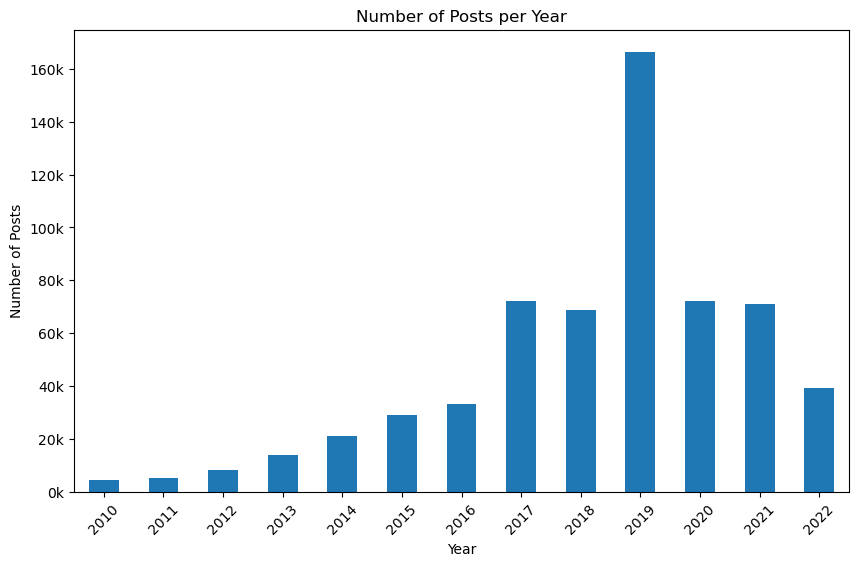

In [10]:
# Count the number of posts per year and sort by year
posts_per_year = preprocessed_posts["year"].value_counts().sort_index()

# Plot the data
plt.figure(figsize=(10, 6))
posts_per_year.plot(kind="bar")
plt.title("Number of Posts per Year")
plt.xlabel("Year")
plt.ylabel("Number of Posts")
plt.xticks(rotation=45)

# Format the y-axis to show numbers in 1000s
formatter = ticker.FuncFormatter(lambda x, pos: f'{int(x/1000)}k')
plt.gca().yaxis.set_major_formatter(formatter)

plt.show()

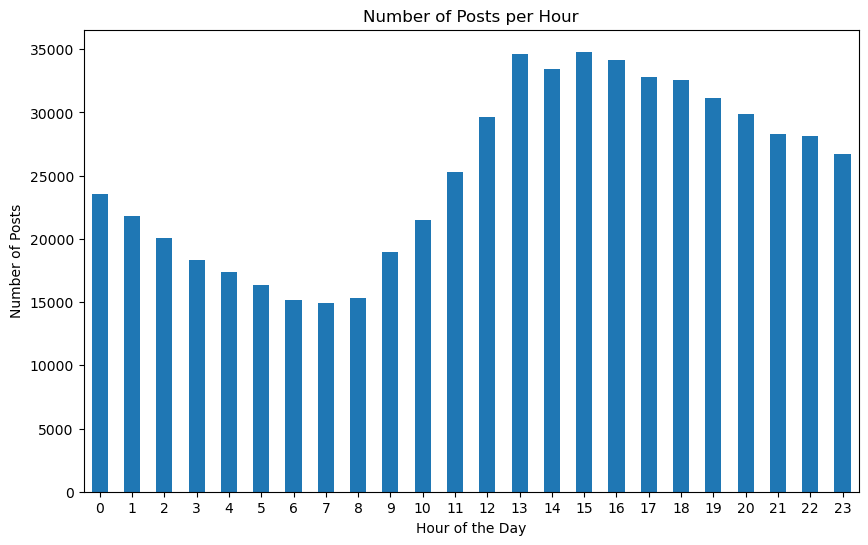

In [22]:
# Extract the hour from the 'created_utc' column
preprocessed_posts["hour"] = preprocessed_posts["created_utc"].dt.hour

# Count the number of posts per hour
posts_per_hour = preprocessed_posts.groupby("hour").size()

# Plot the distribution
plt.figure(figsize=(10, 6))
posts_per_hour.plot(kind="bar")
plt.title("Number of Posts per Hour")
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Posts")
plt.xticks(rotation=0)
plt.show()

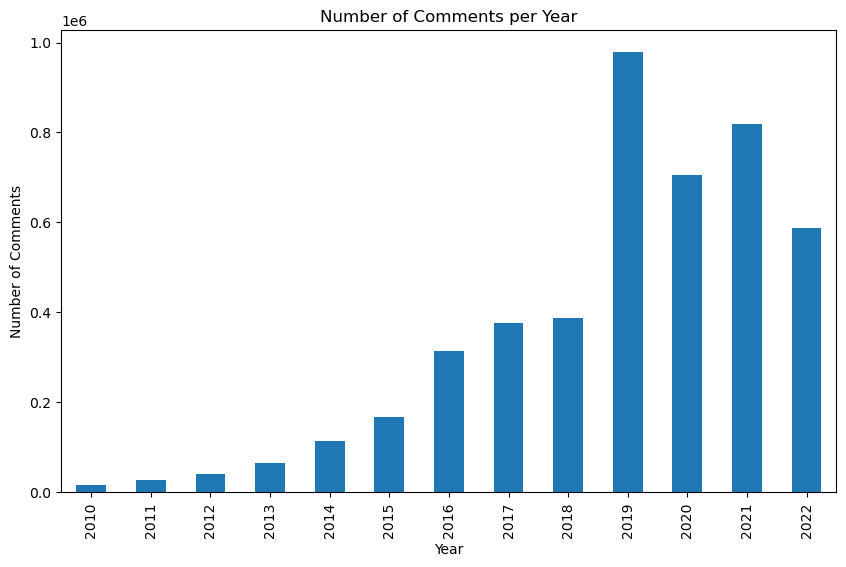

In [23]:
# Count the number of comments per year and sort by year
comments_per_year = raw_comments["year"].value_counts().sort_index()

# Plot the data
plt.figure(figsize=(10, 6))
comments_per_year.plot(kind="bar")
plt.xlabel("Year")
plt.ylabel("Number of Comments")
plt.title("Number of Comments per Year")
plt.show()

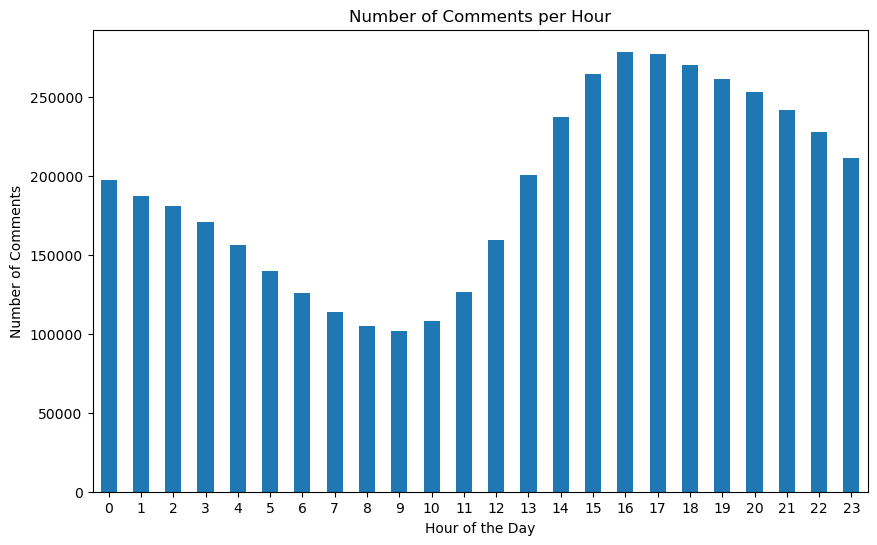

In [24]:
# Extract the hour from the 'created_utc' column
raw_comments["hour"] = raw_comments["created_utc"].dt.hour

# Count the number of comments per hour
comments_per_hour = raw_comments.groupby("hour").size()

# Plot the distribution
plt.figure(figsize=(10, 6))
comments_per_hour.plot(kind="bar")
plt.title("Number of Comments per Hour")
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Comments")
plt.xticks(rotation=0)
plt.show()


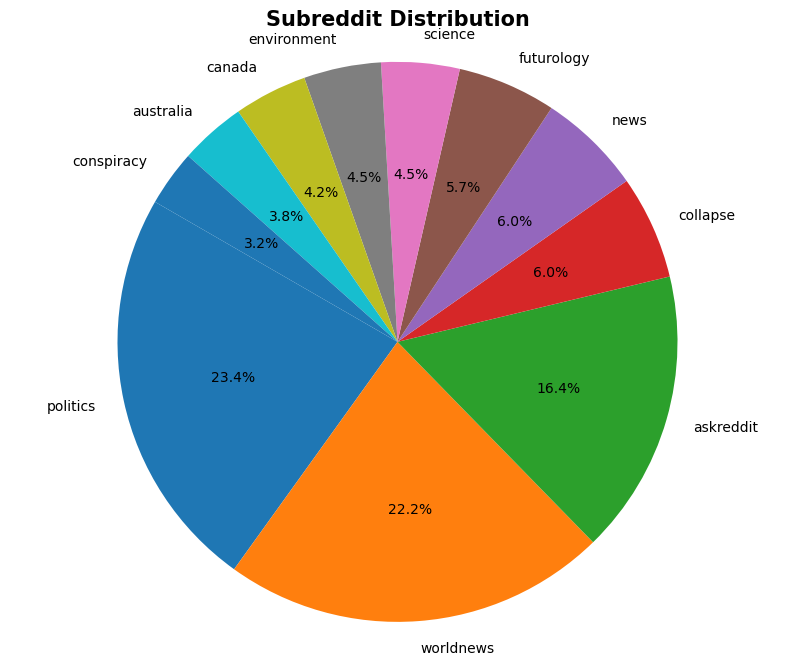

In [25]:
# Calculate the value counts
value_counts = raw_comments["subreddit.name"].value_counts()

# Calculate others
others_count = value_counts[value_counts < 50000].sum()

# Create a new DataFrame for plotting
plot_data = value_counts[value_counts >= 50000]
plot_data["others"] = others_count

# Remove 'others' from the plot_data
plot_data = plot_data[plot_data.index != "others"]

# Create a pie chart without 'others'
plt.figure(figsize=(10, 8))
plt.pie(plot_data, labels=plot_data.index, autopct="%1.1f%%", startangle=150)
plt.axis("equal")  # Equal aspect ratio ensures that pie is drawn as a circle.

# Display the pie chart
plt.title("Subreddit Distribution", fontweight="bold", fontsize=15)
plt.show()

# Word Frequency and Cloud

In [4]:
def most_common_word(dataframe, column, type):
    """
    Find and plot the most common words in a specified column of a dataframe.

    Parameters:
    dataframe (pd.DataFrame): The dataframe containing the data.
    column (str): The column name in the dataframe to analyze.
    type (str): The type of data being analyzed (for plot title).

    Raises:
    ValueError: If the specified column does not exist in the dataframe.
    """
    # Check if the column exists in the dataframe
    if column not in dataframe.columns:
        raise ValueError(f"Column \"{column}\" does not exist in the dataframe.")

    # Combine all comments into a single string
    all_comments = " ".join(dataframe[column].astype(str))

    # Tokenize the string
    tokens = word_tokenize(all_comments)

    # Remove punctuation and lowercase the tokens
    table = str.maketrans("", "", string.punctuation)
    tokens = [word.translate(table) for word in tokens]
    tokens = [word.lower() for word in tokens]

    # Remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]

    # Filter out stopwords
    stop_words = set(stopwords.words("english"))
    tokens = [word for word in tokens if word not in stop_words]

    # Create a frequency distribution
    freq_dist = Counter(tokens)

    # Get the 10 most common words
    most_common = freq_dist.most_common(10)

    print("\nMost common words:")
    for word, freq in most_common:
        print(f"{word}: {freq}")

    # Just exclude climate and change
    most_common_excluding_first_two = most_common[2:]
    plt.figure(figsize=(12, 8))
    plt.bar([word for word, freq in most_common_excluding_first_two], [freq for word, freq in most_common_excluding_first_two])
    plt.title(f"Most Common Words in {type}", fontweight="bold", fontsize=15)
    plt.xlabel("Word")
    plt.ylabel("Frequency")
    plt.xticks(rotation=0)
    plt.show()


Most common words:
climate: 712016
change: 675906
https: 70056
world: 52797
amp: 49759
us: 49388
new: 43788
nt: 42619
people: 41641
http: 41064


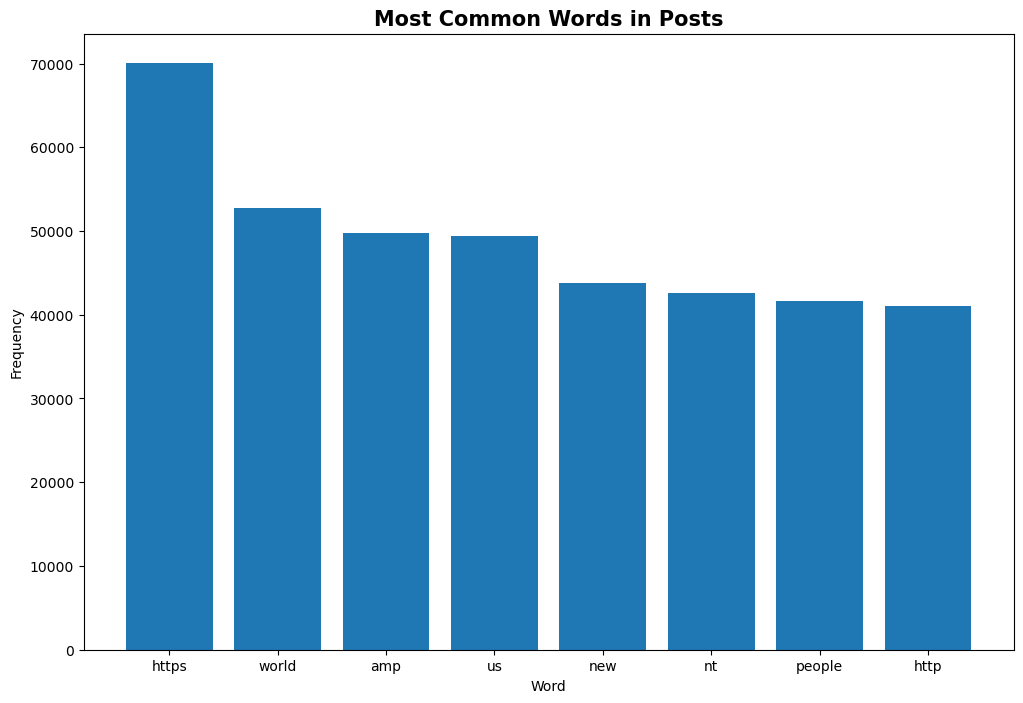

In [27]:
#Apply function on title_and_text
most_common_word(preprocessed_posts, "title_and_text", "Posts")


Most common words:
climate: 728349
change: 687671
world: 53258
new: 44257
people: 41643
global: 38853
trump: 38688
us: 37552
could: 35417
would: 31997


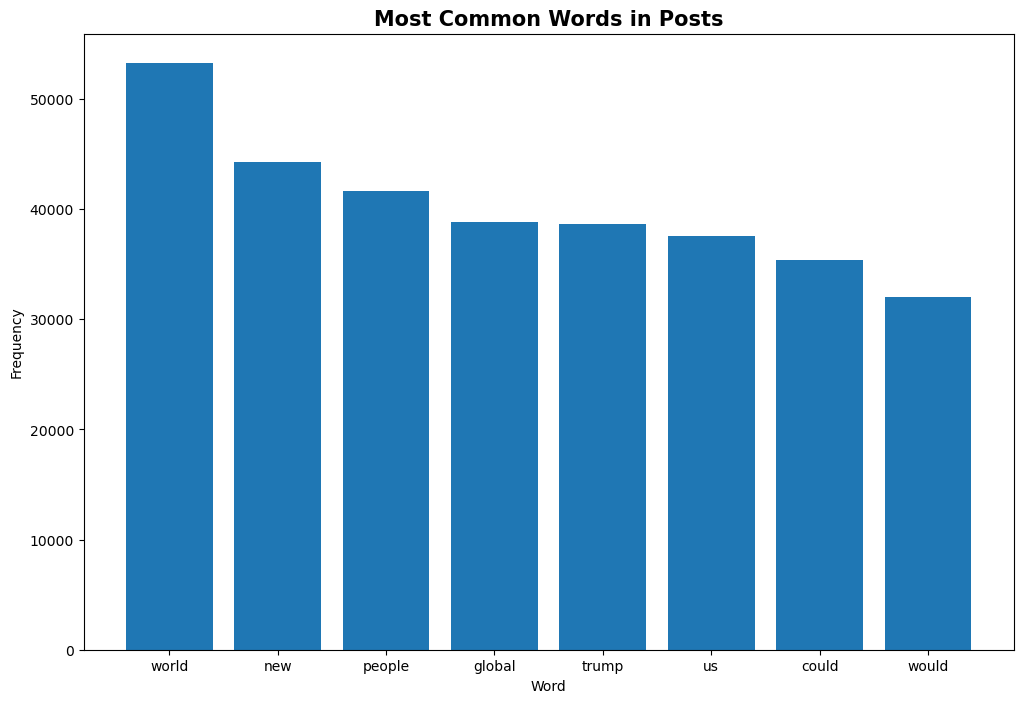

In [28]:
#Apply function on title_and_text_cleaned
most_common_word(preprocessed_posts, "title_and_text_cleaned", "Posts")


Most common words:
climate: 728674
change: 698836
say: 61831
world: 53781
make: 44731
new: 44552
people: 42147
trump: 38856
global: 38853
year: 36907


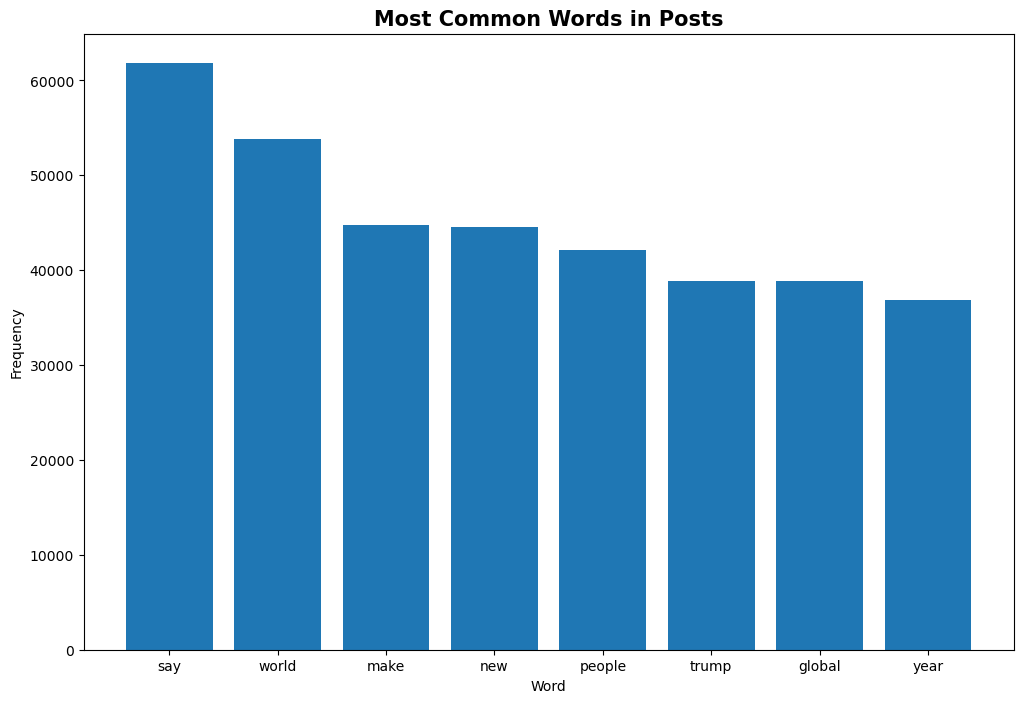

In [29]:
#Apply function on title_and_text_lemmatized
most_common_word(preprocessed_posts, "title_and_text_lemmatized", "Posts")

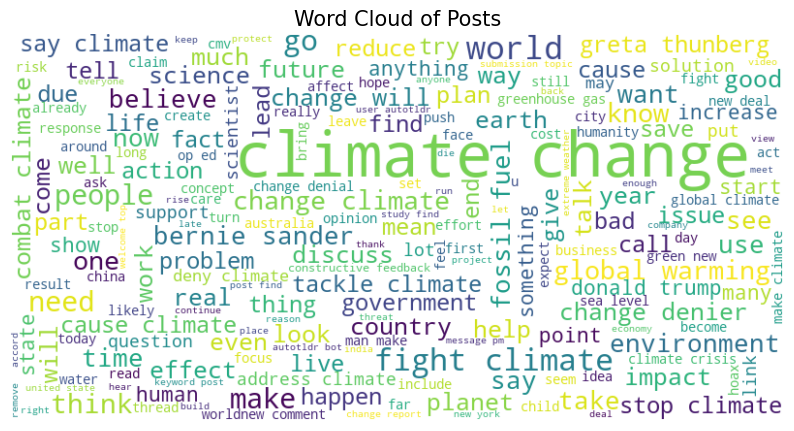

In [7]:
def word_cloud(dataframe, column):
    """
    Generate and display a word cloud from the specified column of a dataframe.

    Parameters:
    dataframe (pd.DataFrame): The dataframe containing the data.
    column (str): The column name in the dataframe to analyze.

    Raises:
    ValueError: If the specified column does not exist in the dataframe.
    """
    # Combine all comments into a single string
    all_comments = " ".join(dataframe[column].astype(str))

    # Create a WordCloud object
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(all_comments)

    # Display the WordCloud
    plt.figure(figsize=(10, 8))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title("Word Cloud of Posts", fontsize=15)
    plt.show()

# Generate and display the word cloud
word_cloud(preprocessed_posts, "title_and_text_lemmatized")

# Sentiment Analysis

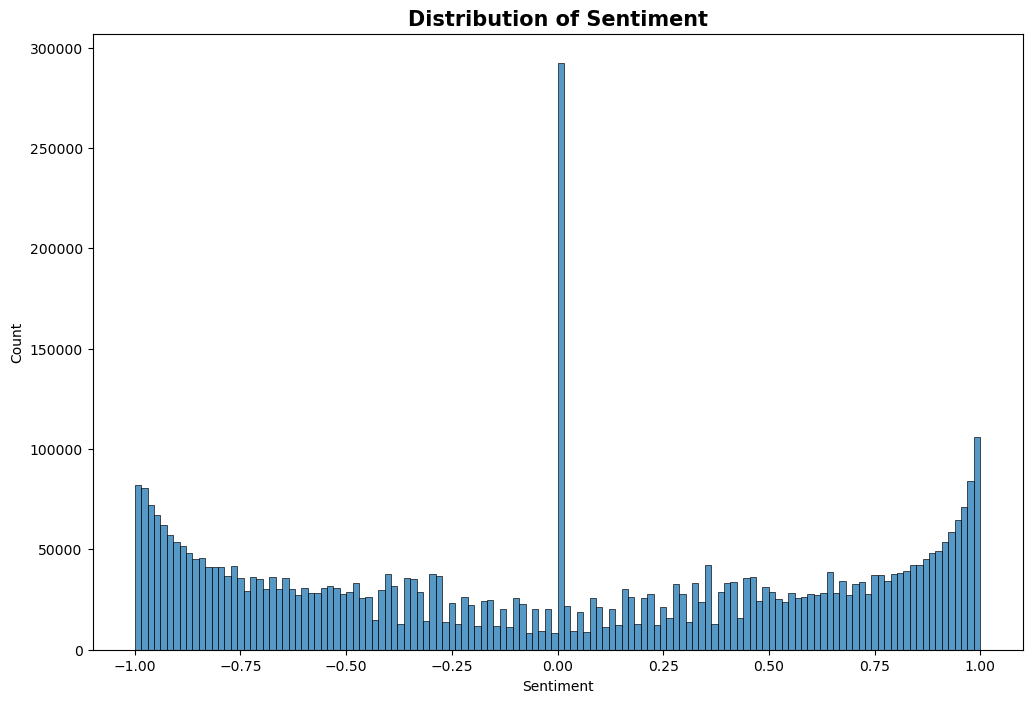

In [31]:
# Create figure and size
plt.figure(figsize=(12, 8))

# Plotting using histplot to include KDE
ax = sns.histplot(raw_comments["sentiment"])
plt.title("Distribution of Sentiment", fontweight="bold", fontsize=15)
plt.xlabel("Sentiment")

# Display the plot
plt.show()

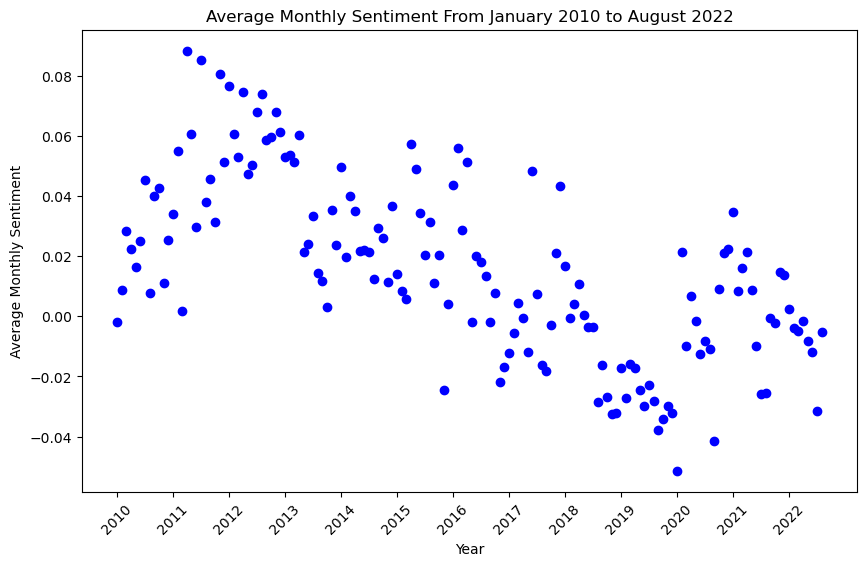

In [9]:
# Calculate average monthly sentiment
avgMonthlySentimentSeries = raw_comments.groupby(pd.PeriodIndex(raw_comments["created_utc"], freq="M"))["sentiment"].mean()

# Convert PeriodIndex to a timestamp for plotting
timestamps = avgMonthlySentimentSeries.index.to_timestamp()

# Plot the data
plt.figure(figsize=(10, 6))
plt.scatter(timestamps, avgMonthlySentimentSeries, color="blue")
plt.title("Average Monthly Sentiment From January 2010 to August 2022")
plt.xlabel("Year")
plt.ylabel("Average Monthly Sentiment")

# Set x-ticks to display every year
years = pd.date_range(start=timestamps.min(), end=timestamps.max(), freq='YS')
plt.xticks(years, years.year, rotation=45)

plt.show()

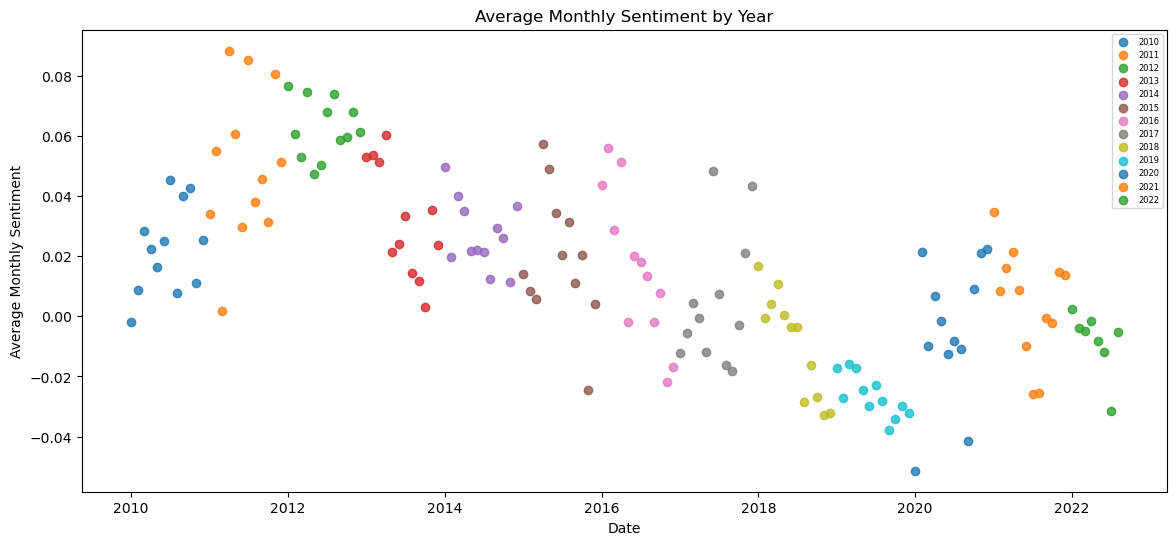

In [33]:
# Create a new figure
plt.figure(figsize=(14, 6)) 

# Calculate average monthly sentiment for each year
avgMonthlySentimentSeries = raw_comments.groupby([raw_comments["created_utc"].dt.year, pd.PeriodIndex(raw_comments["created_utc"], freq="M")])["sentiment"].mean()

# Plot the data for each year
for year, data in avgMonthlySentimentSeries.groupby(level=0):
    # Extract the second level (PeriodIndex) and convert it to timestamp
    months = data.index.get_level_values(1).to_timestamp()
    # Plot the average monthly sentiment scores for the current year as scatter plot
    plt.scatter(months, data, label=year, alpha=0.8 )

# Create plot descirption
plt.title("Average Monthly Sentiment by Year")
plt.xlabel("Date")
plt.ylabel("Average Monthly Sentiment")
plt.legend(loc='upper right', prop={'size': 6})
plt.show()

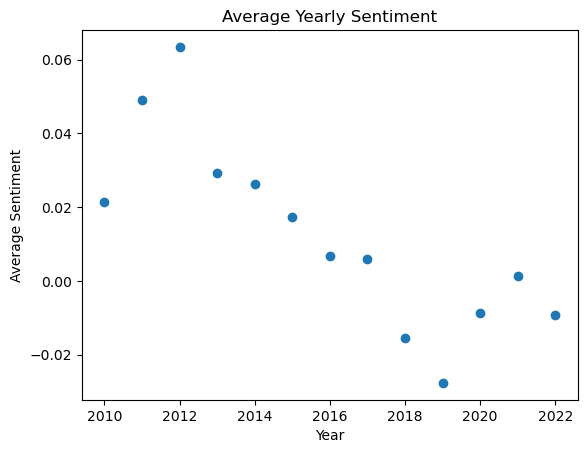

In [34]:
# Group raw_comments DataFrame by year extracted from 'created_utc' column, then calculate the mean sentiment score for each year
avgYearlySentimentSeries = raw_comments.groupby(raw_comments["created_utc"].dt.year)["sentiment"].mean()

# Plot the data
plt.scatter(avgYearlySentimentSeries.index, avgYearlySentimentSeries,  label="Yearly Average Sentiment")
plt.title("Average Yearly Sentiment")
plt.xlabel("Year")
plt.ylabel("Average Sentiment")
plt.show()

# LEIA Emotion Classification

It's necessary to run the analysis on a sample due to runtime.

In [35]:
#Create sample of 50,000 posts
post_sample = preprocessed_posts.sample(n=50000, random_state=42)

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
C:\Users\Jannik Wirtheim\AppData\Roaming\Python\Python311\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


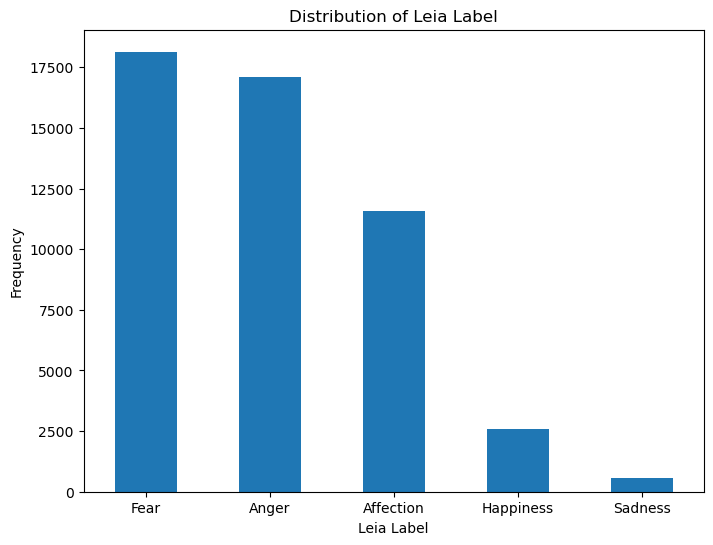

In [36]:
#Loading LEIA as a pipline
pipe = pipeline("text-classification", model="LEIA/LEIA-base", truncation=True, max_length=128)

# Apply Leia to each sentence and store the results in a new column Leia_Label
post_sample["Leia_Label"] = [pipe(text)[0]["label"] for text in post_sample["title_and_text_lemmatized"]]

# Plot the results
plt.figure(figsize=(8, 6))
post_sample['Leia_Label'].value_counts().plot(kind='bar')
plt.title('Distribution of Leia Label')
plt.xlabel('Leia Label')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.show()

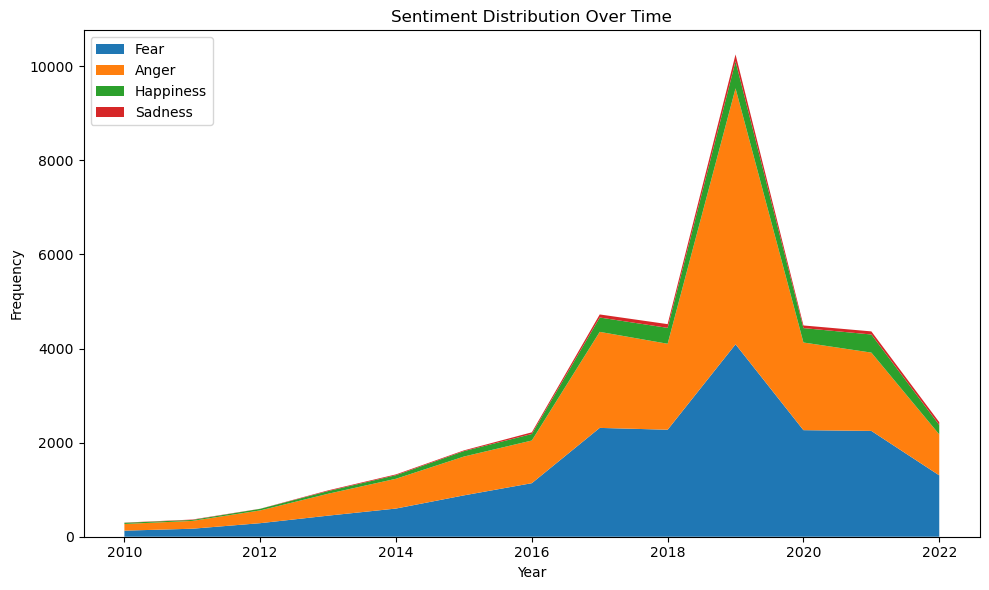

In [37]:
emotion_counts_per_year = post_sample.groupby(['year', 'Leia_Label']).size().unstack(fill_value=0)

# Create the stacked area chart
plt.figure(figsize=(10, 6))
plt.stackplot(emotion_counts_per_year.index, 
              emotion_counts_per_year['Fear'], 
              emotion_counts_per_year['Anger'], 
              emotion_counts_per_year['Happiness'], 
              emotion_counts_per_year['Sadness'],
              labels=['Fear', 'Anger', 'Happiness', 'Sadness'])

# Add titles and labels
plt.title('Sentiment Distribution Over Time')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.legend(loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()

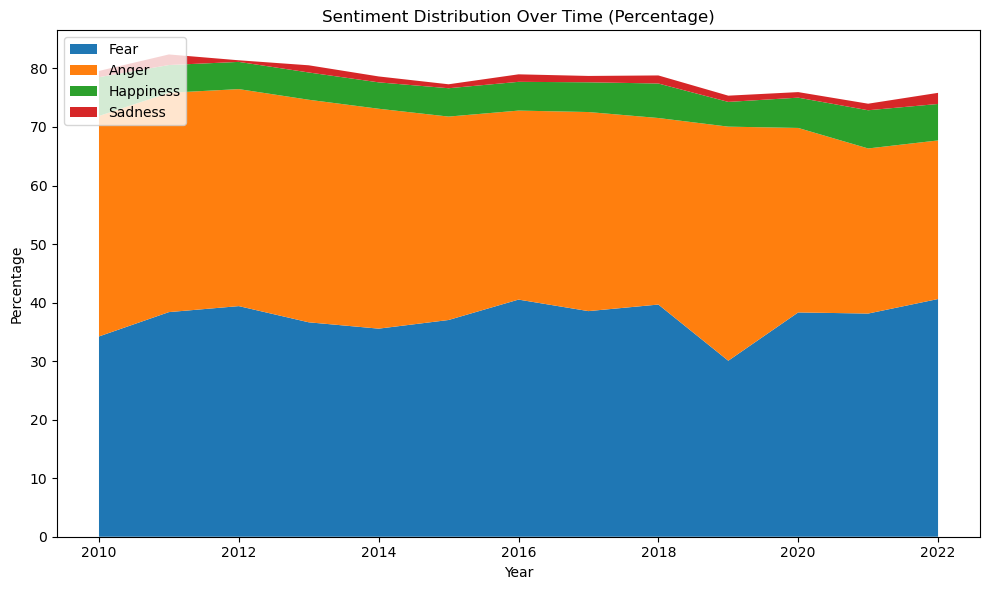

In [38]:
# Group by year and emotion label, then unstack to get counts
emotion_counts_per_year = post_sample.groupby(['year', 'Leia_Label']).size().unstack(fill_value=0)

# Normalize to get percentage representation
emotion_percentage_per_year = emotion_counts_per_year.div(emotion_counts_per_year.sum(axis=1), axis=0) * 100

# Create the stacked area chart
plt.figure(figsize=(10, 6))
plt.stackplot(emotion_percentage_per_year.index, 
              emotion_percentage_per_year['Fear'], 
              emotion_percentage_per_year['Anger'], 
              emotion_percentage_per_year['Happiness'], 
              emotion_percentage_per_year['Sadness'],
              labels=['Fear', 'Anger', 'Happiness', 'Sadness'])

# Add titles and labels
plt.title('Sentiment Distribution Over Time (Percentage)')
plt.xlabel('Year')
plt.ylabel('Percentage')
plt.legend(loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()

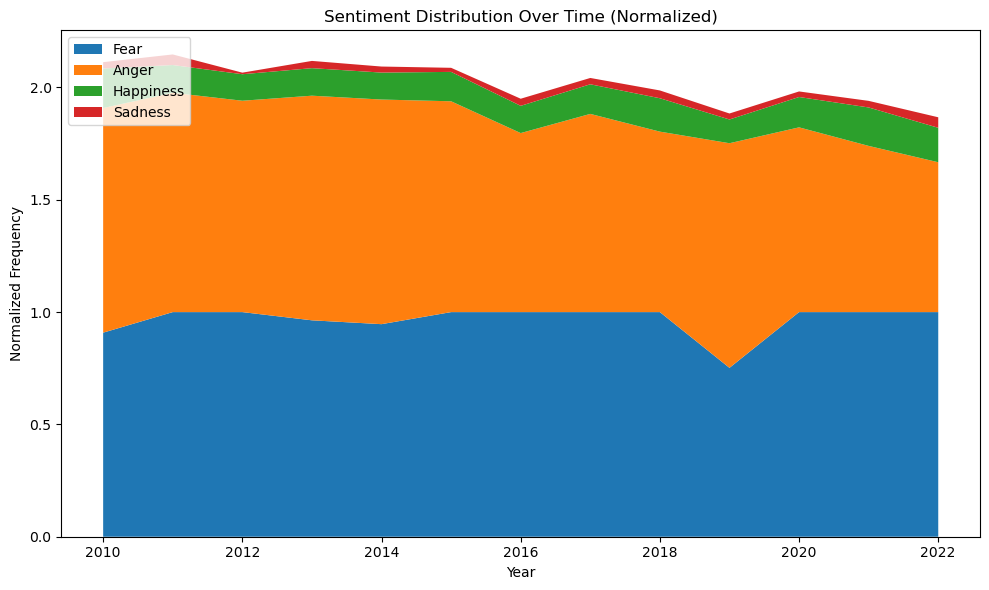

In [39]:
# Group by year and emotion label, then unstack to get counts
emotion_counts_per_year = post_sample.groupby(['year', 'Leia_Label']).size().unstack(fill_value=0)

# Normalize the data (scaling each row to have values between 0 and 1)
emotion_normalized_per_year = emotion_counts_per_year.div(emotion_counts_per_year.max(axis=1), axis=0)

# Create the stacked area chart
plt.figure(figsize=(10, 6))
plt.stackplot(emotion_normalized_per_year.index, 
              emotion_normalized_per_year['Fear'], 
              emotion_normalized_per_year['Anger'], 
              emotion_normalized_per_year['Happiness'], 
              emotion_normalized_per_year['Sadness'],
              labels=['Fear', 'Anger', 'Happiness', 'Sadness'])

# Add titles and labels
plt.title('Sentiment Distribution Over Time (Normalized)')
plt.xlabel('Year')
plt.ylabel('Normalized Frequency')
plt.legend(loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()